In [1]:
import sys, time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

from Environment import *
from Actor import *

In [2]:
#list to tensor
def l2T(x):
    return tf.expand_dims(tf.convert_to_tensor(x), axis=0)

decay_exponent = 5
cut_off = 0.3

def epsilonByProportion(p):
    return (1 - p)**decay_exponent if p < cut_off else 0

In [3]:
%%time
num_trial = 100
num_episode = 20

grid_shape=(8,8)
env = Environment(grid_shape=grid_shape)
actor = Actor(grid_shape=grid_shape)
#env.reset()

save_action, current_action = [], []
loss_curve, avg_lens, max_lens = [], [], []

for trial in range(num_trial):
    epsilon = epsilonByProportion(trial / num_trial)
    #epsilon = 0
    avg_loss = loss_ctr = avg_len = max_len = 0
    
    for episode in range(num_episode):
        current_action = []
        env.reset()
        state = l2T(env.state())
        done = env.done()
        max_len_episode = 0
        
        while not done:
            action = actor.proposeAction(state, epsilon)
            current_action += [action]
            env.applyAction(action)
            
            next_state = l2T(env.state())
            done = env.done()
            reward = env.reward()
            actor.push(state, action, next_state, reward, done)
            
            avg_loss += actor.learn()
            loss_ctr += 1
            if max_len_episode < env.snake.snakeLength():
                max_len_episode = env.snake.snakeLength()
            state = next_state
            
        avg_len += max_len_episode
        if max_len < max_len_episode:
            max_len = max_len_episode

    print('Trial: ' + str(trial+1) + ', Epsilon: ' + str(round(epsilon,3)) \
          + ', Loss: ' + str(round(float(avg_loss) / loss_ctr,3)) \
          + ', Avg length: ' + str(round(avg_len / num_episode, 2)) + ', Max length: ' + str(max_len))
    loss_curve += [avg_loss / loss_ctr]
    avg_lens += [avg_len / num_episode]
    max_lens += [max_len]

Trial: 1, Epsilon: 1.0, Loss: 0.099, Avg length: 3.0, Max length: 3
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\jmcop\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\magics\execution.py", line 1325, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 34, in <module>
  File "C:\Users\jmcop\OneDrive - UCB-O365\Classes\CSCI-5922\Project\Actor.py", line 69, in learn
    self.optimizer.apply_gradients(zip(grads, self.dqn.trainable_variables))
  File "C:\Users\jmcop\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\optimizer.py", line 1230, in apply_gradients
    return super().apply_gradients(grads_and_vars, name=name)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jmcop\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\optimizer.py", line 652, in apply_gradients
    iteration = self._internal_apply_gradients(grads_and_vars)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jmcop\AppData\Local\

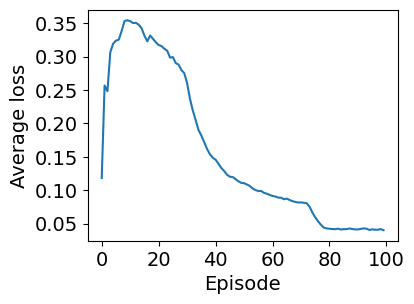

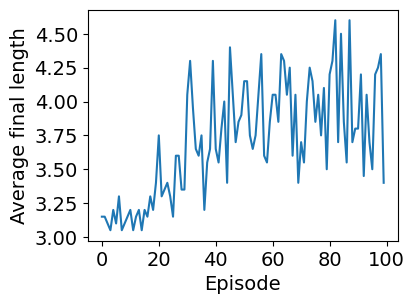

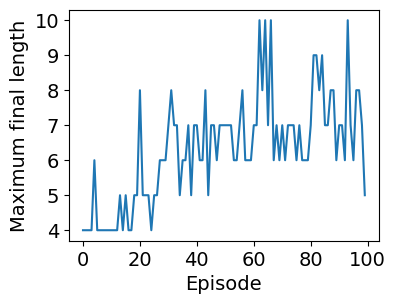

In [99]:
plt.figure(figsize=(4,3))
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Average loss', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(loss_curve)
plt.show()

plt.figure(figsize=(4,3))
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Average final length', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(avg_lens)
plt.show()

plt.figure(figsize=(4,3))
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Maximum final length', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(max_lens)
plt.show()

In [92]:
actor.dqn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 8, 8, 4)           112       
                                                                 
 conv2d_16 (Conv2D)          (None, 4, 4, 4)           404       
                                                                 
 flatten_6 (Flatten)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 16)                1040      
                                                                 
 dense_13 (Dense)            (None, 4)                 68        
                                                                 
Total params: 1624 (6.34 KB)
Trainable params: 1624 (6.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
%%time
num_games = 100

grid_shape=(8, 8)
test_env = Environment(grid_shape=grid_shape)
test_actor = Actor(grid_shape=grid_shape)
test_actor.load()

final_lens = []

for game in range(num_games):
    test_env.reset()
    done = test_env.done()
s
    while not done:
        state = l2T(test_env.state())
        action = test_actor.proposeAction(state, 0)
        test_env.applyAction(action)
        done = test_env.done()

    final_lens += [test_env.snake.snakeLength()]

CPU times: total: 16 s
Wall time: 1min 53s


3.98


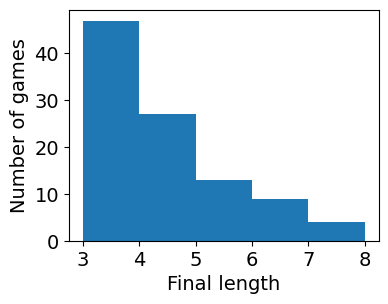

In [22]:
print(np.average(np.array(final_lens)))

plt.figure(figsize=(4,3))
plt.xlabel('Final length', fontsize=14)
plt.ylabel('Number of games', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.hist(final_lens, bins=np.arange(3, max(final_lens)+1))
plt.show()